In [1]:
"""Does statistical analysis"""
from typing import List, Tuple
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

COMMENTS_DATA = "wallstreetbets-posts-and-comments-for-august-2021-comments.csv"
STOCK_DATA = ""

/tmp/ipykernel_48807/2636162392.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def get_market_sentiment():
    """Returns a dataframe of the commment table. It has the timestamp, comment body and sentiment scores.
    Records without a """
    df = pd.read_csv("wallstreetbets-posts-and-comments-for-august-2021-comments.csv")
    df['datetime'] = pd.to_datetime(df.created_utc, unit='s').dt.tz_localize('UTC') #get timestamps
    df = df[['datetime', 'body', 'sentiment']] #pick certain columns
    df =  df[df.sentiment.notna()] #extract rows with existing sentiment scores
    
    gme_mentions = df.body.str.contains("GME", case=False)
    gamestop_mentions = df.body.str.contains("gamestop", case=False)
    return df[gamestop_mentions | gme_mentions]

def get_stock_data():
    df = pd.read_csv("alphavantage_data_GME_2021-08.csv")
    df['datetime'] = pd.to_datetime(df.timestamp)
    return df

def graph_time_series(series1, series2)->None:
    """Graphs 2 """

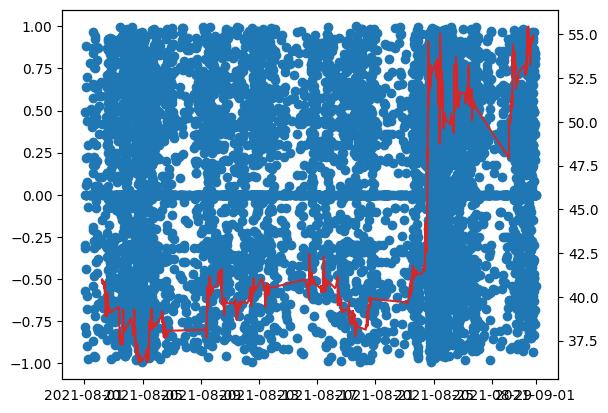

In [4]:
#Sentiment of each comment and  market price against time, in August 2021
comments : pd.DataFrame = get_market_sentiment() 
stocks : pd.DataFrame = get_stock_data()
fig, comments_ax = plt.subplots()
comments_ax.scatter(comments.datetime, comments.sentiment)
stocks_ax = comments_ax.twinx()
stocks_ax.plot(stocks.datetime, stocks.open, color='tab:red')
plt.show()

In [ ]:
#Plot sentiment against market price, in August 2021
comments : pd.DataFrame = get_market_sentiment() 
stocks : pd.DataFrame = get_stock_data()
fig, comments_ax = plt.subplots()
comments_ax.scatter(comments.datetime, comments.sentiment)
stocks_ax = comments_ax.twinx()
stocks_ax.scatter(stocks.datetime, stocks.open, color='tab:red')
plt.show()